In [1]:
# import everything

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read df, add Month, Year, Week Number and Trap without letter columns

df = pd.read_csv('train.csv')
df.Date = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Month'] = df.Date.apply(lambda x: x.month)
df['Year'] = df.Date.apply(lambda x: x.year)
df['Trap2'] = df['Trap'].str[:4]
df['WkNb'] = df.Date.apply(lambda x: float(x.strftime("%U")))

In [3]:
# find all traps that caught WN
twwn = df.groupby(by=['Trap']).WnvPresent.sum().reset_index() 
twwn['TrapsThatCaught'] = twwn.WnvPresent
twwn.drop(['WnvPresent'], axis=1, inplace=True)
df = pd.merge(df, twwn, how = 'left', on = ['Trap']) # Add col for traps that caught WN at any point

In [4]:
# Calculate probabilities of a trap catching WN in a given month
df['Ones'] = np.ones(len(df))
df2 = df.groupby(by=['Trap2', 'Month', 'WnvPresent']).Ones.sum().reset_index()
df2.sort_values('Ones', ascending=False).head(1)

df3 = df2.groupby(['Trap2', 'Month']).Ones.sum().reset_index()
df4 = df2[df2.WnvPresent == 1].groupby(['Trap2', 'Month']).Ones.sum().reset_index()

df5 = pd.merge(df3, df4, how = 'left', on = ['Trap2', 'Month'])
df5.Ones_y[df5.Ones_y.isnull()] = 0
df5['prob'] = df5.Ones_y / df5.Ones_x # Num rows per Trap per Month with WN / Num rows per Trap per Month

df5.prob = (df5.prob)
proba = df5[['Trap2', 'Month', 'prob']]

df6 = pd.merge(df, df5, how = 'left', on = ['Trap2', 'Month'])
a = LabelEncoder().fit_transform(df6.Trap2)
np.unique(a)
se = pd.Series(a)
df6['traps'] = se.values

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# filter out May, June, October, insignificant species & traps that never caught WN
filt = df[((df.Month == 7) | (df.Month == 8) | (df.Month == 9)) & ((df.Species == 'CULEX PIPIENS') | (df.Species == 'CULEX RESTUANS') | (df.Species == 'CULEX PIPIENS/RESTUANS'))]
filt = filt[filt.TrapsThatCaught != 0]
ttc = filt.Trap.unique() # traps that caught

In [100]:
test.shape

(116293, 15)

In [98]:
filt2 = test[((test.Month == 7) | (test.Month == 8) | (test.Month == 9)) & ((test.Species == 'CULEX PIPIENS') | (test.Species == 'CULEX RESTUANS') | (test.Species == 'CULEX PIPIENS/RESTUANS'))]
#filt2.shape
filt2[filt2.Trap2.apply(lambda x: x in ttc)].shape

(27226, 15)

In [6]:
# import & clean test

test = pd.read_csv('test.csv')
test.head()
test.Date = pd.to_datetime(test['Date'], format='%Y-%m-%d')
test['Month'] = test.Date.apply(lambda x: x.month)
test['Year'] = test.Date.apply(lambda x: x.year)
test['Trap2'] = test['Trap'].str[:4]
test['WkNb'] = test.Date.apply(lambda x: float(x.strftime("%U")))

In [7]:
testprob = pd.merge(test, proba, how = 'left', on = ['Trap2', 'Month'])
testprob.prob[testprob.prob.isnull()] = 0
testprob.prob[(testprob.Species == 'CULEX SALINARIUS') | (testprob.Species == 'CULEX TERRITANS') | (testprob.Species == 'CULEX TARSALIS') | (testprob.Species == 'CULEX ERRATICUS') | (testprob.Species == 'UNSPECIFIED CULEX')] = 0
testprob.prob[testprob.Month == 5] = 0
testprob.prob[testprob.Month == 6] = 0
testprob.prob[testprob.Month == 10] = 0
testprob.prob[testprob.Trap.apply(lambda x: x not in ttc)] = 0

a = LabelEncoder().fit_transform(testprob.Trap2)
np.unique(a)
se = pd.Series(a)
testprob['traps'] = se.values

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinas

In [106]:
test[test.Month == 10]

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Month,Year,Trap2,WkNb
65840,65841,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65841,65842,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65842,65843,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65843,65844,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65844,65845,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65845,65846,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TARSALIS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65846,65847,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",UNSPECIFIED CULEX,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65847,65848,2010-10-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX ERRATICUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,10,2010,T002,39.0
65848,65849,2010-10-01,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX PIPIENS/RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,10,2010,T007,39.0
65849,65850,2010-10-01,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,10,2010,T007,39.0


In [8]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

X_train = df6[['traps', 'Month', 'Year', 'prob', 'Latitude', 'Longitude', 'WkNb']]
y_train = df6.WnvPresent

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)

In [9]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [10]:
optimized_GBM.grid_scores_

[mean: 0.68351, std: 0.19392, params: {'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1},
 mean: 0.68974, std: 0.18602, params: {'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1},
 mean: 0.69692, std: 0.19776, params: {'subsample': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1},
 mean: 0.68043, std: 0.22285, params: {'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3},
 mean: 0.67800, std: 0.22837, params: {'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3},
 mean: 0.68634, std: 0.22591, params: {'subsample': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3},
 mean: 0.67164, std: 0.23805, params: {'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5},
 mean: 0.67026, std: 0.23874, params: {'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5},
 mean: 0.67734, std: 0.23387, params: {'subsampl

In [11]:
X_test = testprob[['traps', 'Month', 'Year', 'prob', 'Latitude', 'Longitude', 'WkNb']]
results = optimized_GBM.predict_proba(X_test)

In [38]:
yesorno = optimized_GBM.predict(X_test)
yesorno = pd.DataFrame(yesorno, columns=['yesorno'])
final = final.join(yesorno)

final.yesorno[(final.Species == 'CULEX SALINARIUS') | (final.Species == 'CULEX TERRITANS') | (final.Species == 'CULEX TARSALIS') | (final.Species == 'CULEX ERRATICUS') | (final.Species == 'UNSPECIFIED CULEX')] = 0
final.yesorno[final.Month == 5] = 0
final.yesorno[final.Month == 6] = 0
final.yesorno[final.Month == 10] = 0
final.yesorno[final.Trap.apply(lambda x: x not in ttc)] = 0

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__mai

In [35]:
xgbres = pd.DataFrame(results[:,1], columns=['xgbres'])
final = testprob.join(xgbres)

final.xgbres[(final.Species == 'CULEX SALINARIUS') | (final.Species == 'CULEX TERRITANS') | (final.Species == 'CULEX TARSALIS') | (final.Species == 'CULEX ERRATICUS') | (final.Species == 'UNSPECIFIED CULEX')] = 0
final.xgbres[final.Month == 5] = 0
final.xgbres[final.Month == 6] = 0
final.xgbres[final.Month == 10] = 0
final.xgbres[final.Trap.apply(lambda x: x not in ttc)] = 0

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__mai

In [13]:
p = []

p = pd.DataFrame(p)
p['Id'] = testprob.Id
p['WnvPresent'] = final.xgbres
#print p
p.to_csv('prediction10.csv', index=False)

In [17]:
final.to_csv('final.csv', index=False)

In [82]:
df.Trap2.sort_values().unique()

array(['T001', 'T002', 'T003', 'T004', 'T005', 'T006', 'T007', 'T008',
       'T009', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016', 'T017',
       'T018', 'T019', 'T025', 'T027', 'T028', 'T030', 'T031', 'T033',
       'T034', 'T035', 'T036', 'T037', 'T039', 'T040', 'T043', 'T044',
       'T045', 'T046', 'T047', 'T048', 'T049', 'T050', 'T051', 'T054',
       'T060', 'T061', 'T062', 'T063', 'T065', 'T066', 'T067', 'T069',
       'T070', 'T071', 'T072', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T078', 'T079', 'T080', 'T081', 'T082', 'T083', 'T084', 'T085',
       'T086', 'T088', 'T089', 'T090', 'T091', 'T092', 'T094', 'T095',
       'T096', 'T097', 'T099', 'T100', 'T102', 'T103', 'T107', 'T114',
       'T115', 'T128', 'T129', 'T135', 'T138', 'T141', 'T142', 'T143',
       'T144', 'T145', 'T146', 'T147', 'T148', 'T149', 'T150', 'T151',
       'T152', 'T153', 'T154', 'T155', 'T156', 'T157', 'T158', 'T159',
       'T160', 'T161', 'T162', 'T200', 'T206', 'T209', 'T212', 'T215',
      

In [88]:
test.shape

(116293, 15)

In [107]:
final.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Month,Year,Trap2,WkNb,prob,traps,xgbres,yesorno
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2008,T002,23.0,0.0,1,0.0,0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2008,T002,23.0,0.0,1,0.0,0
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2008,T002,23.0,0.0,1,0.0,0
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2008,T002,23.0,0.0,1,0.0,0
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2008,T002,23.0,0.0,1,0.0,0


In [49]:
test_pp = optimized_GBM.predict_proba(X_train)
print(optimized_GBM.score(X_train, y_train))

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.898959747174


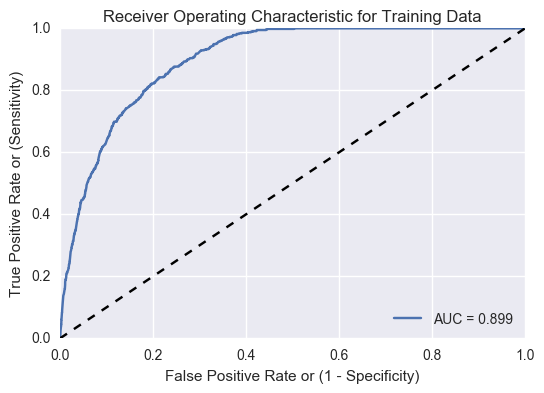

0.898959747174


In [53]:
fpr, tpr, thresholds = roc_curve(y_train, test_pp[:,1])
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc="lower right")
plt.show()

print roc_auc

plt.savefig('train_roc.png')

In [111]:
conmat = np.array(confusion_matrix(y_train, optimized_GBM.predict(X_train), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['has_WNV', 'no_WNV'],
                         columns=['predicted_WNV','predicted_no_WNV'])

print confusion

         predicted_WNV  predicted_no_WNV
has_WNV              8               543
no_WNV               8              9947
